##Import libraries

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
pd.set_option('display.max_columns', None)
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold , cross_val_predict
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier  # Import Random Forest classifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve, auc, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Load data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/sentiment_tweets3.csv')

In [9]:
# Rename two columns
data.rename(columns={'message to examine': 'message', 'label (depression result)': 'label'}, inplace=True)

In [10]:
data1 = data[['message', 'label']]

In [ ]:
data1.dropna(inplace=True)

##Text preprocessing

In [ ]:
data1['message'] = data1['message'].apply(lambda x: ' '.join(word.lower() for word in word_tokenize(x) if word.isalpha()))

In [13]:
stop_words = stopwords.words('english')

In [ ]:
data1['message'] = data1['message'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))

In [ ]:
# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
data1['message'] = data1['message'].apply(lambda x: ' '.join(stemmer.stem(word) for word in word_tokenize(x)))

##KFOLD cross validation

In [16]:
# Set 'X' as the 'message' column and 'y' as the 'label' column
X = data1['message']
y = data1['label']

In [17]:
from sklearn.utils import shuffle
#Trying KFOLDS : to separate out into 3 folds, each has train and test sets
kf = KFold(shuffle=True, random_state=7218, n_splits =3)

##GloVe for Feature Engineering / Text Representation

In [18]:
# Define the path to the GloVe file containing pre-trained word vectors (must be downloaded from GloVe website)
glove_file = '/glove/glove.6B.100d.txt'

In [19]:
# Create an empty dictionary to store word vectors from the GloVe file
glove_vectors = {}
# Open the GloVe file, read each line, and store word vectors in the dictionary
try:
  with open(glove_file, 'r', encoding='utf-8') as file:
      for line in file:
          values = line.split()       #Splits each line into a list of strings using whitespace as the default separator.
                                      #The line represents a word followed by its corresponding vector values in the file.
          word = values[0]                            #Retrieves the first element from the values list, which is the word itself
          vector = np.array(values[1:], dtype='float32') # [float(val) for val in values[1:]]               #Constructs a list comprehension to convert the string values in values[1:] (excluding the first element which is the word) to floating-point numbers (floats). These are the components of the word's vector representation
          glove_vectors[word] = vector                 #Assigns the word as the key and its associated vector (a list of float values) as the value in the glove_vectors dictionary
except FileNotFoundError:
    print(f"File {glove_file} not found.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

In [20]:
# define a function to convert our text data to GloVe word embeddings
# vectorization
def text_to_embeddings(text, word_vectors, embedding_dim=100):  #size of the vectors (vectors == embeddings)
    embeddings = [word_vectors.get(word, np.zeros(embedding_dim)) for word in word_tokenize(text)]

    if not embeddings:
        return np.zeros(embedding_dim)

    return np.mean(embeddings, axis=0)

##Train & validation :

Scaling our data

Define our classifier

In [21]:
# Lists to store results from each fold
accuracy_scores=[]
precision_scores=[]
recall_scores=[]

# Lists to store true and predicted labels for confusion matrix
all_y_true = []
all_y_pred = []
conf_matrix =[]

# Standardizing and using SVM classifier
s = StandardScaler()
rf_classifier = RandomForestClassifier(n_estimators=100, bootstrap=True, min_samples_split=2, random_state=42)

accuracy_scores
[0.9450261780104712, 0.9456079115764979, 0.9476439790575916]
precision_scores
[0.9458737137402059, 0.9466381177425733, 0.9484654840616304]
recall
[0.9450261780104712, 0.9456079115764979, 0.9476439790575916]
conf_matrix_kfold 
 [[7932   68]
 [ 488 1826]]


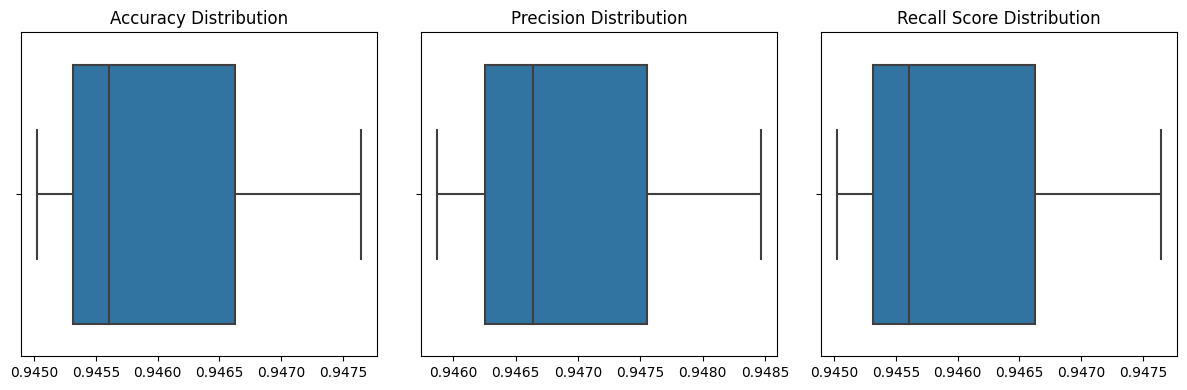

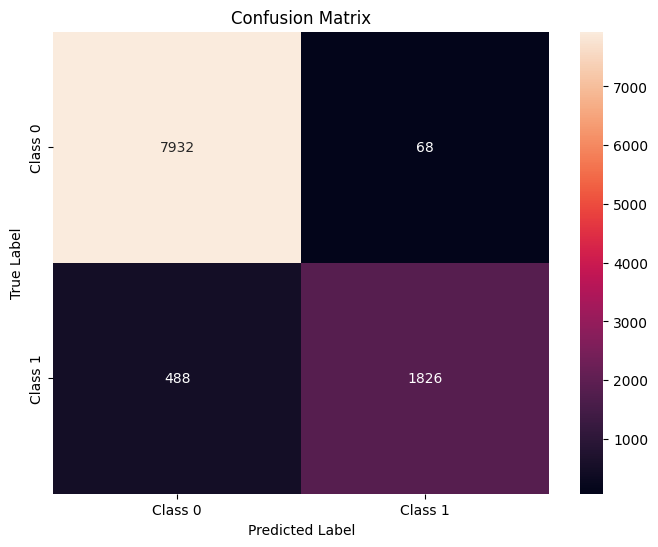

In [22]:
# For each fold, split our X into train & validation
for train_index, val_index in kf.split(X):

  # split our X switch the indexes
  X_train, X_val, y_train, y_val =(X[train_index], X[val_index], y[train_index], y[val_index])

  # Apply our defined function : "text_to_embeddings" to x_train & x_val
  X_train_embedded = np.array([text_to_embeddings(text, glove_vectors) for text in X_train])
  X_val_embedded = np.array([text_to_embeddings(text, glove_vectors) for text in X_val])

  # Using RandomOverSampler to oversample the minority class
  oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
  X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_embedded, y_train)

  # Define our pipeline : scaling then, svm classifier
  estimator = Pipeline([('scale', s), ('rf', rf_classifier)])

  # Fit and then predict for each fold
  estimator.fit(X_train_resampled, y_train_resampled)
  y_pred = estimator.predict(X_val_embedded)

  accuracy_fold = accuracy_score(y_val, y_pred)
  accuracy_scores.append(accuracy_fold)

  # Calculate recall for the fold
  recall_fold = recall_score(y_val, y_pred, average='weighted')
  recall_scores.append(recall_fold)

  precision_fold = precision_score(y_val, y_pred, average='weighted')
  precision_scores.append(precision_fold)

  # Conf matrix : Append true and predicted labels to the lists
  all_y_true.extend(y_val)
  all_y_pred.extend(y_pred)

# Conf matrix : Generate the overall confusion matrix for k-fold cross-validation
conf_matrix_kfold = confusion_matrix(all_y_true, all_y_pred)
#true label being i-th class and predicted label being j-th class

print("accuracy_scores")
print(accuracy_scores)
print("precision_scores")
print(precision_scores)
print("recall")
print(recall_scores)
print("conf_matrix_kfold \n", conf_matrix_kfold)

# Visualize metrics
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 3, 1)
sns.boxplot(x=accuracy_scores)
plt.title('Accuracy Distribution')

# Precision plot
plt.subplot(1, 3, 2)
sns.boxplot(x=precision_scores)
plt.title('Precision Distribution')

# recall Score plot
plt.subplot(1, 3, 3)
sns.boxplot(x=recall_scores)
plt.title('Recall Score Distribution')

plt.tight_layout()
plt.show()

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_kfold, annot=True, fmt='d', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()